<a href="https://colab.research.google.com/github/mhtabkrklt/Datascience/blob/main/Callcenter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предсказание звонков в коллцентр

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

sessions = pd.read_parquet('sessions.parquet').sort_values('date_time')

train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

print('train shape:', train.shape)
print('test shape:', test.shape)
print('sessions shape:', sessions.shape)

train.head(3)

train shape: (104595, 6)
test shape: (17196, 5)
sessions shape: (3334243, 6)


,order_id,create_time,good_id,price,sessionkey_id,is_callcenter
0,1269921,1975-12-26 09:30:08,9896348,753,123777004,1
1,1270034,1975-12-26 10:28:57,9896348,753,123781654,0
2,1268272,1975-12-25 11:24:28,9896348,753,123591002,1


**order_id:** id заказа

**create_time:** время заказа

**good_id**: id товара

**price:** цена товара

**sessionkey_id:** id сессия пользователя

**is_callcenter:** звонил ли от коллцентра

In [4]:
test.head(3)

,order_id,create_time,good_id,price,sessionkey_id
0,1350922,1976-02-05 15:08:37,9896348,1143,132744630
1,1354989,1976-02-07 15:26:00,69445048,1707,133161905
2,1352637,1976-02-06 11:43:58,70607886,576,132792626


In [5]:
sessions.head(3)

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,good_id
2268917,109996122,1975-10-17 13:42:56.953,2,1,11.0,None
2268918,109996122,1975-10-17 13:43:07.510,2,2,22.0,None
2268919,109996122,1975-10-17 13:43:29.860,2,3,25.0,None


In [6]:
train.is_callcenter.value_counts(normalize=True)

,proportion
is_callcenter,
0,0.645308
1,0.354692


In [7]:
train.create_time = pd.to_datetime(train.create_time)
test.create_time = pd.to_datetime(test.create_time)
train.create_time

,create_time
0,1975-12-26 09:30:08
1,1975-12-26 10:28:57
2,1975-12-25 11:24:28
3,1975-12-26 14:16:06
4,1975-12-26 18:21:47
...,...
104590,1975-12-16 12:11:32
104591,1975-11-08 11:29:50
104592,1975-11-12 09:14:35
104593,1975-11-10 17:28:07


In [8]:
train.create_time.max()

Timestamp('1976-01-31 20:56:30')

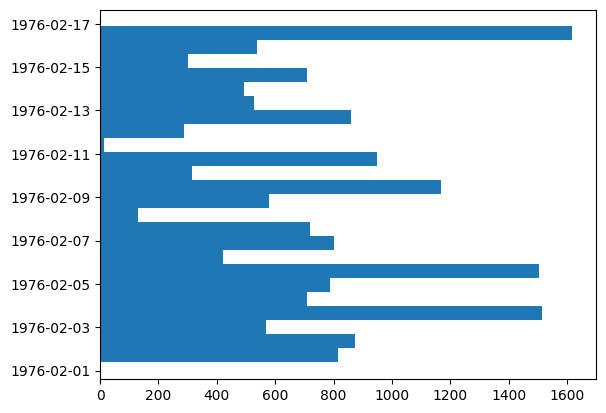

In [9]:
plt.hist(test.create_time, bins=24, orientation='horizontal')
plt.show()

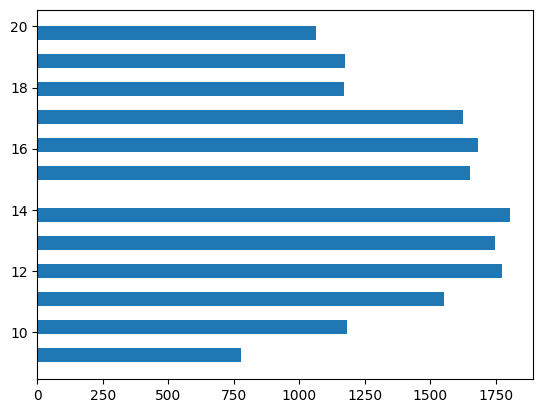

In [10]:
plt.hist(test.create_time.dt.hour, bins=24, orientation='horizontal')
plt.show()

у нас действительно хорошо работает колл-центр потому что на графике видно что большинство заказы сделаны днем(9ч-20ч) по время работы колл-центра

In [11]:
sessions.sessionkey_id.value_counts().iloc[24000:24020]
sessions[sessions.sessionkey_id == 132659450].tail(5)

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,good_id
1978254,132659450,1976-02-05 09:28:39.617,2,26,20.0,None
1978255,132659450,1976-02-05 09:28:59.390,2,27,298.0,None
1888000,132659450,1976-02-05 09:33:57.437,1,28,187.0,68947912
2217403,132659450,1976-02-05 09:37:04.943,3,29,25.0,None
1888001,132659450,1976-02-05 09:46:06.143,3,34,NaN,None


In [12]:
sessions['good_id_isnull'] = sessions.good_id.isnull()
sessions.groupby('page_type')['good_id_isnull'].mean()

,good_id_isnull
page_type,
1,0.051337
2,1.000000
3,1.000000
4,1.000000
5,1.000000
6,1.000000
7,1.000000
8,1.000000
9,1.000000


здесь у нас видно что id товора никогда не указан, он указан только у первый типа страниц то можем делать вывод что это возможно карточка товара

#### Достаем для каждого заказа данные по сессии

In [13]:
sessions['page_type'].value_counts()

,count
page_type,
1,1291547
2,942031
3,363690
4,249798
5,147524
6,132745
7,83318
8,81054
9,26793


**Собираем агрегаты по сессиям**

In [14]:
 %%time

session_aggregates = (
    sessions
    .sort_values('date_time')
    .groupby('sessionkey_id')
    .agg(
        date_time_min=pd.NamedAgg(column='date_time', aggfunc=lambda x: x.iloc[0]),
        date_time_max=pd.NamedAgg(column='date_time', aggfunc=lambda x: x.iloc[-1]),
        ends_with_nan_sec=pd.NamedAgg(column='pageview_duration_sec', aggfunc=lambda x: pd.isna(x.iloc[-1])),
        session_pages_cnt=pd.NamedAgg(column='pageview_duration_sec', aggfunc=lambda x: x.shape[0]),
        sec_on_last_page=pd.NamedAgg(column='pageview_duration_sec', aggfunc=lambda x: x.iloc[-1])
    )
)
session_aggregates

CPU times: user 48.9 s, sys: 287 ms, total: 49.2 s
Wall time: 49.4 s


,date_time_min,date_time_max,ends_with_nan_sec,session_pages_cnt,sec_on_last_page
sessionkey_id,,,,,
109996122,1975-10-17 13:42:56.953,1975-10-17 13:44:26.633,True,7,NaN
110019268,1975-10-17 15:25:56.300,1975-10-17 15:28:41.860,True,3,NaN
110020180,1975-10-17 15:29:52.147,1975-10-17 15:29:52.147,True,1,NaN
110040418,1975-10-17 17:05:41.530,1975-10-17 17:15:33.020,True,11,NaN
110044482,1975-10-17 17:27:55.297,1975-10-17 17:27:55.297,True,1,NaN
...,...,...,...,...,...
134626779,1976-02-16 20:47:13.283,1976-02-16 20:47:13.283,False,1,22.0
134627402,1976-02-16 20:50:10.233,1976-02-16 20:55:09.017,True,7,NaN
134628420,1976-02-16 20:54:40.853,1976-02-16 20:59:14.477,True,5,NaN


In [15]:
session_aggregates.ends_with_nan_sec.value_counts(normalize=True)

,proportion
ends_with_nan_sec,
True,0.888104
False,0.111896


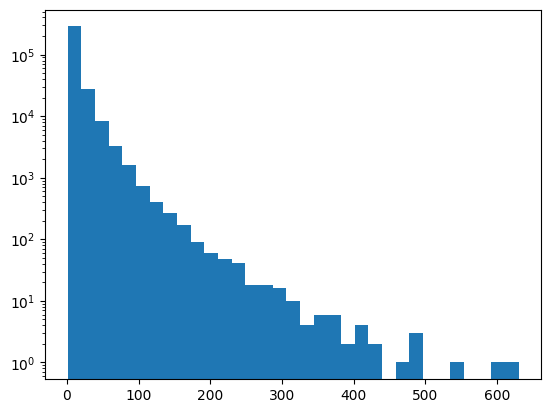

In [18]:
plt.hist(session_aggregates.session_pages_cnt, bins=33)
plt.yscale('log')
plt.show()

In [19]:
session_aggregates.date_time_min = pd.to_datetime(session_aggregates.date_time_min)
session_aggregates.date_time_max = pd.to_datetime(session_aggregates.date_time_max)
session_aggregates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 328430 entries, 109996122 to 134629277
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date_time_min      328430 non-null  datetime64[ns]
 1   date_time_max      328430 non-null  datetime64[ns]
 2   ends_with_nan_sec  328430 non-null  bool          
 3   session_pages_cnt  328430 non-null  int64         
 4   sec_on_last_page   36750 non-null   float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1)
memory usage: 12.8 MB


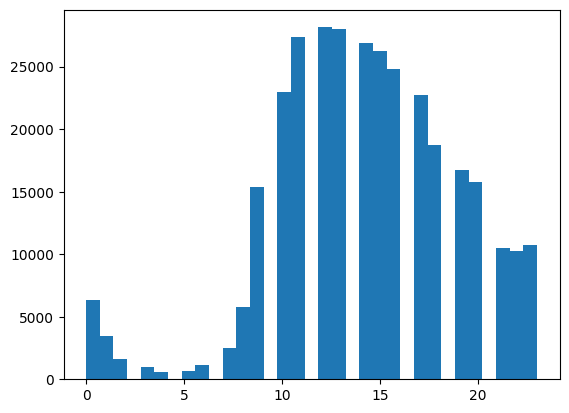

In [20]:
plt.hist(session_aggregates.date_time_max.dt.hour, bins=33)
plt.show()

сессия смотрится круглосуточно и ночью мало

**Присоединяем агрегаты к заказам**

In [21]:
train = train.merge(session_aggregates, on='sessionkey_id', how='left')
train

,order_id,create_time,good_id,price,sessionkey_id,is_callcenter,date_time_min,date_time_max,ends_with_nan_sec,session_pages_cnt,sec_on_last_page
0,1269921,1975-12-26 09:30:08,9896348,753,123777004,1,1975-12-26 09:21:03.393,1975-12-26 09:21:03.393,True,1.0,NaN
1,1270034,1975-12-26 10:28:57,9896348,753,123781654,0,1975-12-26 09:50:26.857,1975-12-26 11:01:03.407,True,28.0,NaN
2,1268272,1975-12-25 11:24:28,9896348,753,123591002,1,1975-12-25 11:17:02.940,1975-12-25 11:23:12.517,True,7.0,NaN
3,1270544,1975-12-26 14:16:06,9896348,753,123832302,1,1975-12-26 13:57:51.157,1975-12-26 14:29:57.153,True,6.0,NaN
4,1270970,1975-12-26 18:21:47,9896348,753,123881603,0,1975-12-26 18:10:27.970,1975-12-26 18:17:54.257,False,6.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...
104590,1250981,1975-12-16 12:11:32,68657110,1497,121795335,1,1975-12-16 12:04:02.273,1975-12-16 12:56:06.990,True,9.0,NaN
104591,1173775,1975-11-08 11:29:50,60391507,1354,114277105,1,1975-11-07 23:37:34.260,1975-11-07 23:55:00.773,True,10.0,NaN
104592,1180920,1975-11-12 09:14:35,66971400,1452,114972131,0,1975-11-12 08:37:30.500,1975-11-12 09:15:26.047,False,39.0,8.0
104593,1177882,1975-11-10 17:28:07,60391498,1433,114672813,1,1975-11-10 17:00:21.517,1975-11-10 17:23:02.973,True,9.0,NaN


#### Исследуем взаимосвязь между is_callcenter и временем заказа, временем сессии

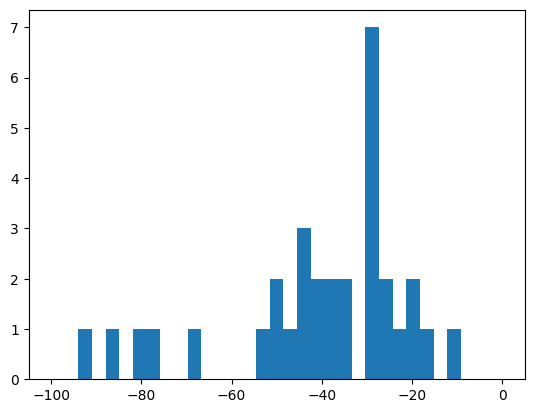

In [22]:
train['order_sec_after_session_start'] = (train.create_time - train.date_time_min).dt.total_seconds()
plt.hist(train.order_sec_after_session_start, bins=33, log=False, range=(-100, 0))
plt.show()

In [39]:
(train.order_sec_after_session_start < 0).value_counts()

,count
order_sec_after_session_start,
False,104553
True,42


есть 42 заказа, сделанных до начало сессии

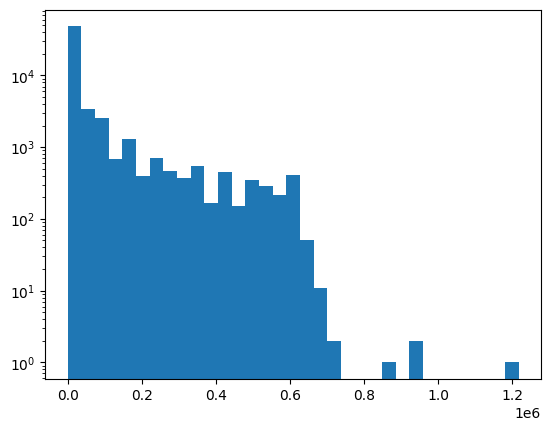

In [24]:
train['order_sec_before_session_end'] = (train.create_time - train.date_time_max).dt.total_seconds() - train.sec_on_last_page.fillna(0)
plt.hist(train.query('order_sec_before_session_end > 0').order_sec_before_session_end, bins=33, log=True)
plt.show()

In [25]:
(train.order_sec_before_session_end < 0).value_counts(normalize=True).round(2)

,proportion
order_sec_before_session_end,
False,0.59
True,0.41


59% звонок сделаны после конца сессии и 41% звонок сделаны вовремя сессии

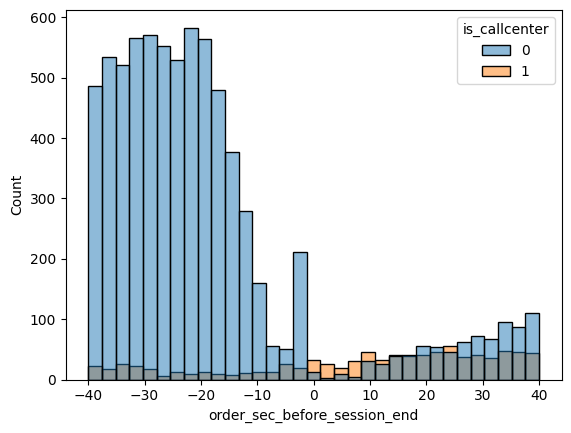

In [26]:
import seaborn as sns

sns.histplot(train, x='order_sec_before_session_end', hue='is_callcenter', bins=33, binrange=(-40, 40))
# plt.yscale('log')
plt.show()

мы заметим что если заказ был сделан на 10 сек после открытие то скорее звонок будет

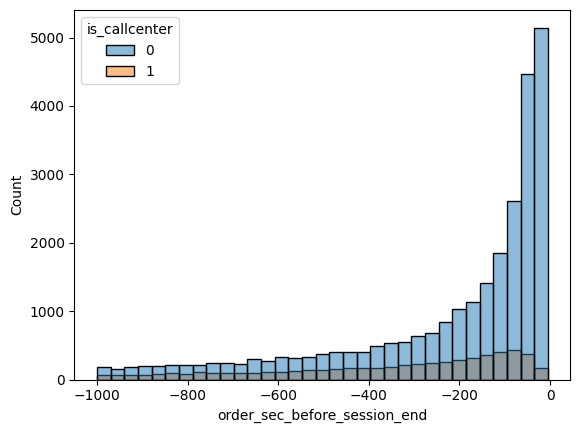

In [41]:
sns.histplot(train.query('ends_with_nan_sec == 1 and order_sec_before_session_end < 0'), x='order_sec_before_session_end', hue='is_callcenter', bins=33, binrange=(-1000, -5))
# plt.yscale('log')
plt.show()

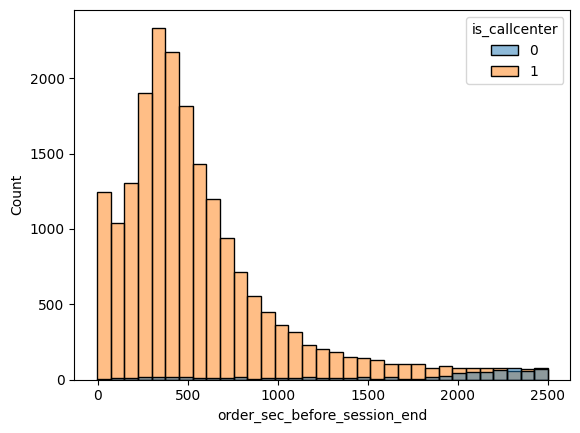

In [55]:
sns.histplot(train.query('ends_with_nan_sec == 1 and order_sec_before_session_end < 2500'), x='order_sec_before_session_end', hue='is_callcenter', bins=33, binrange=(-5, 2500))
#plt.yscale('log')
plt.show()

In [50]:
train.query('ends_with_nan_sec == 0 and order_sec_before_session_end < 2000').is_callcenter.value_counts(normalize=True)

,proportion
is_callcenter,
0,0.97369
1,0.02631


In [44]:
train.query('ends_with_nan_sec == 0 and order_sec_before_session_end > 0').is_callcenter.value_counts(normalize=True)

,proportion
is_callcenter,
0,0.958413
1,0.041587


### Наблюдения по поведению заказов в зависимости от завершения сессии и времени заказа

1. **Если заказ был сделан после окончания сессии:**
   - В случаях, когда сессия завершилась на **NaN_sec**, вероятность звонка составляет **98%** при условии, что прошло менее **2000 секунд**.
   - Если сессия завершилась не на **NaN_sec**, вероятность звонка значительно снижается до **95%**.

2. **Если заказ был сделан во время сессии:**
   - Если сессия завершилась на **NaN_sec**, вероятность звонка составляет **96%**.
   - В случае, если сессия завершилась не на **NaN_sec**, вероятность звонка возрастает до **80%**.

# **"Предскажем" значения `is_callcenter` для тренировочной выборки и посчитаем качество предсказания**

In [29]:
import numpy as np

y_pred = np.zeros(train.shape[0])
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [30]:
train['y_pred'] = y_pred
train.loc[(train.ends_with_nan_sec == 1) & (train.order_sec_before_session_end > -5) & (train.order_sec_before_session_end < 2000), 'y_pred'] = 1
train.y_pred.value_counts(normalize=True)

,proportion
y_pred,
0.0,0.811798
1.0,0.188202


In [31]:
(train.y_pred == train.is_callcenter).mean()

np.float64(0.8271619102251542)

In [32]:
(0 == train.is_callcenter).mean()

np.float64(0.6453080931210861)

#### "Предскажем" значения `is_callcenter` для тестовой выборки

In [35]:
test

,order_id,create_time,good_id,price,sessionkey_id
0,1350922,1976-02-05 15:08:37,9896348,1143,132744630
1,1354989,1976-02-07 15:26:00,69445048,1707,133161905
2,1352637,1976-02-06 11:43:58,70607886,576,132792626
3,1350050,1976-02-05 11:26:19,61918401,436,132683062
4,1341733,1976-02-01 19:36:32,37964900,573,131789790
...,...,...,...,...,...
17191,1358397,1976-02-09 16:13:20,74484779,236,131980166
17192,1357968,1976-02-09 14:30:59,75277186,108,133527708
17193,1358835,1976-02-09 18:39:45,75382827,602,133585500
17194,1365692,1976-02-12 17:50:18,76012025,818,133876415


In [36]:
test = test.merge(session_aggregates, on='sessionkey_id', how='left')
test

,order_id,create_time,good_id,price,sessionkey_id,date_time_min,date_time_max,ends_with_nan_sec,session_pages_cnt,sec_on_last_page
0,1350922,1976-02-05 15:08:37,9896348,1143,132744630,1976-02-05 15:03:26.523,1976-02-05 15:04:28.867,False,2.0,7.0
1,1354989,1976-02-07 15:26:00,69445048,1707,133161905,1976-02-07 15:08:53.093,1976-02-07 15:27:26.593,True,3.0,NaN
2,1352637,1976-02-06 11:43:58,70607886,576,132792626,1976-02-05 18:18:32.887,1976-02-05 18:34:59.477,True,3.0,NaN
3,1350050,1976-02-05 11:26:19,61918401,436,132683062,1976-02-05 11:03:51.383,1976-02-05 11:09:28.247,False,2.0,1046.0
4,1341733,1976-02-01 19:36:32,37964900,573,131789790,1976-02-01 09:50:46.893,1976-02-01 09:53:54.103,True,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...
17191,1358397,1976-02-09 16:13:20,74484779,236,131980166,1976-02-02 09:02:14.140,1976-02-02 09:02:14.140,True,1.0,NaN
17192,1357968,1976-02-09 14:30:59,75277186,108,133527708,1976-02-09 14:23:57.060,1976-02-09 14:26:24.480,False,3.0,59.0
17193,1358835,1976-02-09 18:39:45,75382827,602,133585500,1976-02-09 18:29:05.303,1976-02-09 18:30:36.407,True,3.0,NaN
17194,1365692,1976-02-12 17:50:18,76012025,818,133876415,1976-02-12 16:08:44.033,1976-02-12 16:13:15.153,False,17.0,7.0


In [37]:
test['order_sec_before_session_end'] = (test.create_time - test.date_time_max).dt.total_seconds() - test.sec_on_last_page.fillna(0)
test

,order_id,create_time,good_id,price,sessionkey_id,date_time_min,date_time_max,ends_with_nan_sec,session_pages_cnt,sec_on_last_page,order_sec_before_session_end
0,1350922,1976-02-05 15:08:37,9896348,1143,132744630,1976-02-05 15:03:26.523,1976-02-05 15:04:28.867,False,2.0,7.0,241.133
1,1354989,1976-02-07 15:26:00,69445048,1707,133161905,1976-02-07 15:08:53.093,1976-02-07 15:27:26.593,True,3.0,NaN,-86.593
2,1352637,1976-02-06 11:43:58,70607886,576,132792626,1976-02-05 18:18:32.887,1976-02-05 18:34:59.477,True,3.0,NaN,61738.523
3,1350050,1976-02-05 11:26:19,61918401,436,132683062,1976-02-05 11:03:51.383,1976-02-05 11:09:28.247,False,2.0,1046.0,-35.247
4,1341733,1976-02-01 19:36:32,37964900,573,131789790,1976-02-01 09:50:46.893,1976-02-01 09:53:54.103,True,4.0,NaN,34957.897
...,...,...,...,...,...,...,...,...,...,...,...
17191,1358397,1976-02-09 16:13:20,74484779,236,131980166,1976-02-02 09:02:14.140,1976-02-02 09:02:14.140,True,1.0,NaN,630665.860
17192,1357968,1976-02-09 14:30:59,75277186,108,133527708,1976-02-09 14:23:57.060,1976-02-09 14:26:24.480,False,3.0,59.0,215.520
17193,1358835,1976-02-09 18:39:45,75382827,602,133585500,1976-02-09 18:29:05.303,1976-02-09 18:30:36.407,True,3.0,NaN,548.593
17194,1365692,1976-02-12 17:50:18,76012025,818,133876415,1976-02-12 16:08:44.033,1976-02-12 16:13:15.153,False,17.0,7.0,5815.847


In [38]:
test['y_pred'] = 0
test.loc[(test.ends_with_nan_sec == 1) & (test.order_sec_before_session_end > -5) & (test.order_sec_before_session_end < 2000), 'y_pred'] = 1
test.y_pred.value_counts(normalize=True)

,proportion
y_pred,
0,0.845662
1,0.154338
